<a href="https://colab.research.google.com/github/PedroAlmeida18/Algorimoeestruradedados/blob/main/CSTR_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CSTR Temperature Control

The objective of this case study is to <a href="https://apmonitor.com/pdc/index.php/Main/StirredReactor">automatically maintain a temperature in stirred tank reactor with a highly exothermic reaction</a>. This is an example of a highly nonlinear process that is prone to exponential run-away when the temperature rises too quickly.

A reactor is used to convert a hazardous chemical A to an acceptable chemical B in waste stream before entering a nearby lake. This particular reactor is dynamically modeled as a Continuously Stirred Tank Reactor (CSTR) with a simplified kinetic mechanism that describes the conversion of reactant A to product B with an irreversible and exothermic reaction. Because the analyzer for product B is not fast enough for real-time control, it is desired to maintain the temperature at a constant set point that maximizes the consumption of A (highest possible temperature).

<img width=50% src="https://apmonitor.com/pdc/uploads/Main/cstr_schematic.png">

### Doublet Test for FOPDT Fit

Perform the necessary open loop tests to determine a first order plus dead time (FOPDT) model that describes the relationship between cooling jacket temperature (MV=$T_c$) and reactor temperature (CV=$T$). Use the file cstr_data.txt to extract the information for the FOPDT model. Obtain an FOPDT model and report the values of the three parameters $K_p$, $\tau_p$, and $\theta_p$.

Below is a step test example in Python. Modify this to start at 300K for the cooling jacket temperature, step up to 303K, down to 297K, and back to 300K in a doublet test.



##Tradução : Controle de Temperatura do CSTR
O objetivo deste estudo de caso é manter automaticamente a temperatura em um reator agitado continuamente (CSTR) onde ocorre uma reação fortemente exotérmica. Este é um exemplo de processo altamente não linear e sujeito a runaway exponencial quando a temperatura aumenta muito rápido.

Um reator é usado para converter a substância química perigosa A em uma substância aceitável B no fluxo de efluente antes de entrar em um lago próximo. Este reator em particular é modelado dinamicamente como um Reator Contínuo de Tanque Agitado (CSTR) com um mecanismo cinético simplificado que descreve a conversão do reagente A em produto B por uma reação irreversível e exotérmica. Como o analisador para o produto B não é rápido o suficiente para controle em tempo real, deseja-se manter a temperatura em um ponto de ajuste constante que maximize o consumo de A (temperatura mais alta possível).

Teste doublet para ajuste FOPDT
Realize os testes em malha aberta necessários para determinar um modelo de primeira ordem com tempo morto (FOPDT — First Order Plus Dead Time) que descreva a relação entre a temperatura da jaqueta de resfriamento (MV =
𝑇
𝑐
T
c
	​

) e a temperatura do reator (CV =
𝑇
T). Use o arquivo cstr_data.txt para extrair a informação necessária para o modelo FOPDT. Obtenha um modelo FOPDT e reporte os valores dos três parâmetros
𝐾
𝑝
K
p
	​

,
𝜏
𝑝
τ
p
	​

 e
𝜃
𝑝
θ
p
	​

.

Abaixo há um exemplo de teste de degrau em Python. Modifique-o para começar em 300 K para a temperatura da jaqueta de resfriamento, subir para 303 K, descer para 297 K, e voltar para 300 K em um teste doublet.

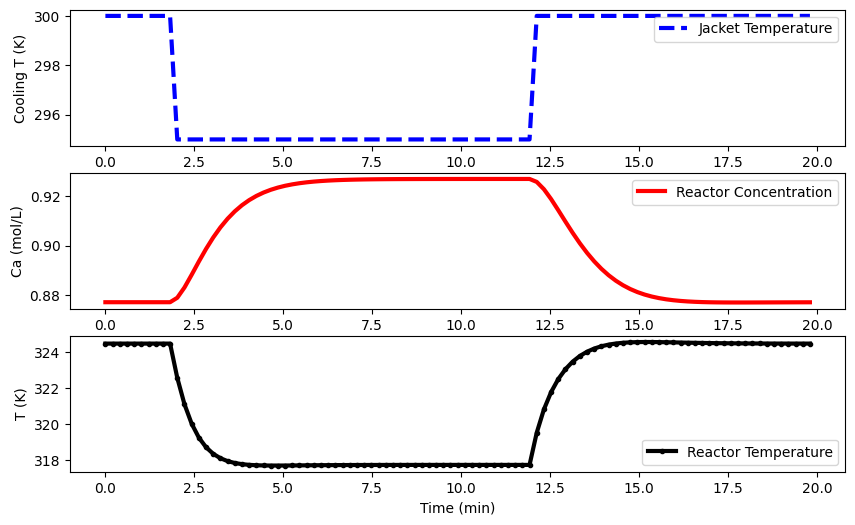

In [ ]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
#Importações

#Indica como será o gráfico, animado ou não
animate=True # True / False

# define CSTR model, Essa função descreve o modelo matemático do reator, ou seja, as equações diferenciais que governam a concentração e temperatura.
#x: vetor de estados → [Ca, T]
  #x = [Ca, T]
  #Ca: concentração do reagente A (mol/m³)
  #T: temperatura do reator (K)
#t: tempo (s ou min)
#u: variável manipulada → temperatura do fluido de resfriamento (Tc)
#Tf: temperatura de alimentação (feed)
#Caf: concentração de A na alimentação

def cstr(x,t,u,Tf,Caf):
    Tc = u # A variável de entrada u corresponde à temperatura do fluido de resfriamento (Tc).”
    Ca = x[0] #x[0] → primeiro elemento do vetor → concentração Ca
    T = x[1]  #x[1] → segundo elemento do vetor → temperatura T

    # Parameters:
    q = 100 # (m³/sec) — vazão volumétrica.
            # é o volume de fluido que entra (e sai) do reator por segundo. Em um CSTR perfeitamente agitado a vazão de entrada = vazão de saída.
            # aumentar q tende a diminuir o tempo de residência, reduzir conversão (menor consumo de A) e aproximar Ca e T dos valores de alimentação Caf e Tf.

    V = 100  # Volume of CSTR (m³) — volume do reator.
             # volume total do fluido dentro do reator (tanque).
             # maior V → maior tempo de residência (fluxo tem menos efeito instantâneo), dinâmica mais lenta.

    rho = 1000 # Densidade da Mistura A-B (kg/m³).
               # massa por volume da mistura reator (densidade). Para água pura, ~1000 kg/m³.
               # maior densidade → maior massa por volume → maior inércia térmica (mesmo calor causa menor variação de temperatura).

    Cp = 0.239 # Calor específico da mistura A-B (J/kg-K)
               # calor específico da mistura (energia necessária para elevar 1 kg da mistura em 1 K).
               # menor Cp → para a mesma liberação de calor, a temperatura sobe mais rápido.

    mdelH = 5e4 # Calor de reação para A->B (J/mol)
                # quantidade de energia liberada (se exotérmica) ou absorvida (se endotérmica) por mol de A que reage.
                # maior mdelH → maior aquecimento por unidade de reação → risco de runaway térmico se não compensado pelo resfriamento.

    # E - Representa a barreira de energia mínima que as moléculas do reagente precisam superar para que a reação química ocorra.
          # É uma constante característica de cada reação.
          # Quanto maior a energia de ativação, mais “difícil” é a reação ocorrer a baixas temperaturas.(J/mol)

    # R - Universal Gas Constant = 8.31451 J/mol-K
          # É usada para relacionar energia, temperatura e quantidade de mols em diversas equações físicas e químicas (como a equação de Arrhenius e a equação dos gases ideais).
    EoverR = 8750  # Essa variável armazena o quociente da energia de ativação pela constante dos gases. (EvorR = E/R)
                   # É uma forma simplificada e prática de escrever a equação de Arrhenius no código.
                   # quanto maior EoverR, mais sensível a taxa de reação à temperatura — pequenas mudanças em T provocam grandes variações em rA.

    k0 = 7.2e10 # Fator pré-exponencial (1/seg).
                # fator pré-exponencial da constante de reação na lei de Arrhenius
                # maior k0 → maior velocidade base de reação (em todas as temperaturas), aumentando consumo de A e liberação de calor.

    # U - Coeficiente global de transferência de calor (W/m^2-K)
          # Representa a eficiência global de troca de calor entre dois meios que estão separados por uma parede (no caso, o reator e a camisa de resfriamento).
    # A - Área de troca térmica (m^2)
        # Corresponde à área de contato entre o reator e o fluido de resfriamento.Quanto maior a área, mais calor pode ser trocado.

    UA = 5e4  # Esse valor indica a capacidade total do sistema de trocar calor por unidade de diferença de temperatura
              #  maior UA → maior capacidade de resfriamento/aquecimento através da jaqueta → melhor controlo térmico.


    rA = k0*np.exp(-EoverR/T)*Ca  # taxa de reação de Arrinus
                                  # taxa volumétrica de reação — mols de A consumidos por m³ por segundo. Depende da concentração Ca (ordem 1 por Ca) e da temperatura via Arrhenius.
                                  # por causa do termo exponencial, rA pode aumentar muito com temperatura;
                                  # isso cria acoplamento forte entre T e Ca e é a origem da não linearidade e do risco de runaway térmico.


    dCadt = q/V*(Caf - Ca) - rA # É o balanço de massa para o reagente A no CSTR (derivada temporal da concentração CA).
# É o balanço de energia (derivada temporal da temperatura T) por unidade de tempo.
    dTdt = q/V*(Tf - T)   + mdelH/(rho*Cp)*rA + UA/V/rho/Cp*(Tc-T)

    # Return xdot:
    xdot = np.zeros(2) # Cria um vetor (array) de 2 posições, inicialmente com zeros:
    xdot[0] = dCadt  # Atribui à primeira posição do vetor xdot a derivada da concentração CA
    xdot[1] = dTdt # Atribui à segunda posição do vetor xdot a deriavda da Temperatura
    return xdot  # Retorna o valor

# Condições de estado em regime permanente
Ca_ss = 0.87725294608097
T_ss = 324.475443431599
x0 = np.empty(2)
x0[0] = Ca_ss
x0[1] = T_ss

# Condições de entrada
u_ss = 300.0
Tf = 350
Caf = 1

# Tempo de simulação
tfinal = 20
n = 100 # Numero de amostras
t = np.linspace(0,tfinal,n)  # 0	Início do intervalo	O tempo inicial da simulação é 0 minutos.
                           # O tempo final da simulação é 10 minutos.
                           # O vetor terá 100 pontos igualmente espaçados entre 0 e 10.

# Armazene os resultados para plotagem
Ca = np.ones(len(t)) * Ca_ss  # Cria um vetor Ca (concentração de A no reator) do mesmo tamanho que o vetor de tempo *
T = np.ones(len(t)) * T_ss
u = np.ones(len(t)) * u_ss

# Antes do tempo correspondente ao índice 10 → o fluido estava a 300 K.
# Depois desse ponto → ele cai para 295 K.
u[10:] = 295
u[60:] = 300

plt.figure(figsize=(9,7))

# Permite ver a evolução dinâmica da concentração e da temperatura do reator à medida que o tempo avança
if animate:
    plt.ion()
    plt.show()

# Simulate CSTR
for i in range(len(t)-1):
    ts = [t[i],t[i+1]] # Define o intervalo de tempo atual para a integração numérica.
    y = odeint(cstr,x0,ts,args=(u[i+1],Tf,Caf)) # odeint é uma função do SciPy usada para resolver equações diferenciais ordinárias (EDOs)
    Ca[i+1] = y[-1][0]  #  Armazena o último valor calculado de Ca e T  no vetor principal.
    T[i+1] = y[-1][1]     #Isso preenche os vetores Ca e T com os resultados da simulação ao longo de todo o t
    x0[0] = Ca[i+1]       # O estado final atual (Ca e T no tempo t[i+1]) vira o novo estado inicial para o próximo passo da integração.
    x0[1] = T[i+1]

    # plot results
    if animate:
        display.clear_output(wait=True)
        plt.figure(figsize=(10,6))  # Limpa a tela (clear_output) e cria uma nova figura para plotar os gráficos atualizados.
        # Mostra a variação de u (Tc) ao longo do tempo — o degrau de 300 → 295 K que você aplicou.
        plt.subplot(3,1,1)
        plt.plot(t[0:i+1],u[0:i+1],'b--',linewidth=3)
        plt.ylabel('Cooling T (K)')
        plt.legend(['Jacket Temperature'],loc='best')

        # Mostra  Ca conforme a reação A → B ocorre
        plt.subplot(3,1,2)
        plt.plot(t[0:i+1],Ca[0:i+1],'r-',linewidth=3)
        plt.ylabel('Ca (mol/L)')
        plt.legend(['Reactor Concentration'],loc='best')

        # Mostra a resposta térmica do reator — como a temperatura do fluido de resfriamento afeta a temperatura dentro do CSTR.
        plt.subplot(3,1,3)
        plt.plot(t[0:i+1],T[0:i+1],'k.-',linewidth=3)
        plt.ylabel('T (K)')
        plt.xlabel('Time (min)')
        plt.legend(['Reactor Temperature'],loc='best')
        plt.pause(0.01)

#Estão indicando o que será salvo em cada coluna do arquivo de saída:

#Tempo (t)
#Temperatura de resfriamento (u, que é Tc)
#Temperatura do reator (T)
data = np.vstack((t,u,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('cstr_data.txt',data,delimiter=',',comments="",header='time,u,y') # Salvando o arquivo

# Plot the results
if not animate:
    plt.subplot(3,1,1)
    plt.plot(t,u,'b--',linewidth=3)
    plt.ylabel('Cooling T (K)')
    plt.legend(['Jacket Temperature'],loc='best')

    plt.subplot(3,1,2)
    plt.plot(t,Ca,'r-',linewidth=3)
    plt.ylabel('Ca (mol/L)')
    plt.legend(['Reactor Concentration'],loc='best')

    plt.subplot(3,1,3)
    plt.plot(t,T,'k.-',linewidth=3)
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')

    plt.show()

### Fit FOPDT with Optimization

Fit $K_p$, $\tau_p$, and $\theta_p$ of an FOPDT model using optimization to achieve the best match to the simulated CSTR data. Use optimization to obtain the same parameters in the FOPDT model (see example optimization code) or use <a href="https://pidtuner.com">PIDTuner.com</a>.

/tmp/ipython-input-3878542959.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ym[i+1] = y1[-1]


Initial SSE Objective: 154.25871259431412
Final SSE Objective: 2.042852289677205
Kp: 1.3734585058305655
taup: 0.500685799169232
thetap: 3.021737269802921e-08


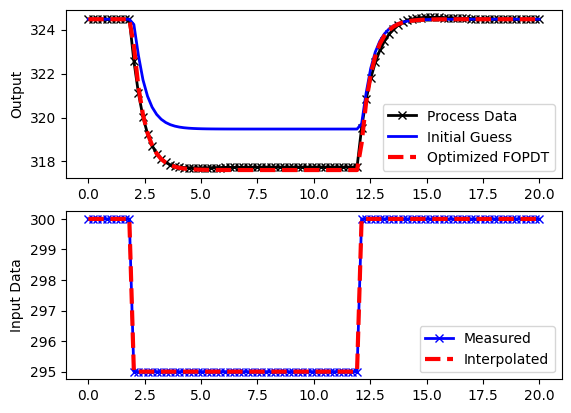

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Import CSV data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
file = 'cstr_data.txt'
data = pd.read_csv(file)
t = data['time'].values - data['time'].values[0]
u = data['u'].values
yp = data['y'].values
u0 = u[0]
yp0 = yp[0]

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]
# create linear interpolation of the u data versus time
uf = interp1d(t,u)

# define first-order plus dead-time approximation
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant
    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        #print('Error with time extrapolation: ' + str(t))
        um = u0
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

# simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(x):
    # input arguments
    Km = x[0]
    taum = x[1]
    thetam = x[2]
    # storage for model values
    ym = np.zeros(ns)  # model
    # initial condition
    ym[0] = yp0
    # loop through time steps
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(uf,Km,taum,thetam))
        ym[i+1] = y1[-1]
    return ym

# define objective
def objective(x):
    # simulate model
    ym = sim_model(x)
    # calculate objective
    obj = 0.0
    for i in range(len(ym)):
        obj = obj + (ym[i]-yp[i])**2
    # return result
    return obj

# initial guesses
x0 = np.zeros(3)
x0[0] = 1.0 # Km
x0[1] = 0.5 # taum
x0[2] = 0.1 # thetam

# show initial objective
print('Initial SSE Objective: ' + str(objective(x0)))

# optimize Km, taum, thetam
#solution = minimize(objective,x0)

# Another way to solve: with bounds on variables
bnds = ((0.5, 3.0), (0.2, 2.0), (0.0, 0.2))
solution = minimize(objective,x0,bounds=bnds,method='SLSQP')
x = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(x)))

print('Kp: ' + str(x[0]))
print('taup: ' + str(x[1]))
print('thetap: ' + str(x[2]))

# calculate model with updated parameters
ym1 = sim_model(x0)
ym2 = sim_model(x)
# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t,ym1,'b-',linewidth=2,label='Initial Guess')
plt.plot(t,ym2,'r--',linewidth=3,label='Optimized FOPDT')
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()

### Design PI or PID Controller

Use the $K_p$, $\tau_p$, and $\theta_p$ from the FOPDT model in the Internal Model Control (IMC) PI tuning correlation or PID tuning correlation to obtain starting values of $K_c$, $\tau_I$, and $\tau_D$ for a <a href="https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralControl">PI controller</a> or <a href="https://apmonitor.com/pdc/index.php/Main/ProportionalIntegralDerivative">PID controller</a>. Use an aggressive value for the closed loop time constant, $\tau_c=0.1 \tau_p$.

### Implement PI or PID Controller

Using $K_c$, $\tau_I$, and $\tau_D$ from the IMC tuning correlation, implement a PID controller with anti-reset windup. Test the set point tracking capability of this controller by plotting the response of the process to steps in set point of the reactor temperature (not cooling jacket temperature) from 300K up to 320K and then down to 280K. Limit the cooling jacket temperature between 250K and 350K. Comment on how the nonlinear behavior of this process impacts your observed set point response performance.

### Tune PI or PID Controller

Improve the tuning by adjusting $K_c$, $\tau_I$, and $\tau_D$ by trial and error until the controller displays a 10% to 15% overshoot in response to a reactor temperature set point step from 300K to 320K. Plot this set point step response.

### Challenge: Lowest Concentration

Step up the set point to achieve a maximum temperature in the reactor without exceeding the maximum allowable temperature of 400K (don’t cause a reactor run-away). What is the lowest concentration that can be achieved without exceeding the maximum allowable temperature? This is a very difficult problem due to the potential for reactor temperature run-away. Derivative action may be necessary to achieve the best performance.

### Sample PID Code

The following code is an implementation of a PID controller but is unable to keep the reactor temperature below the upper limit of 400K.

#Código final

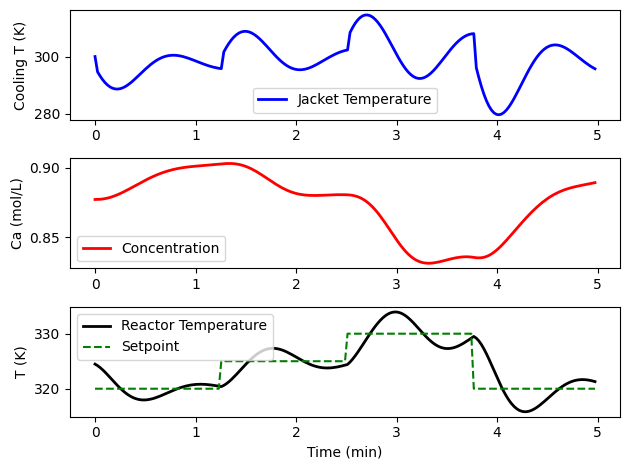


IEA por setpoint: [1.75849436 1.970012   3.07782328 3.35120681]

SII por setpoint : [ 4.04631831  8.75174032 19.34960261 34.43225476]
IEA Total da simulação: 10.1575
SII total de simulação : 66.5799


In [8]:
# Importações e dependências
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from cstr_model import cstr
import pandas as pd

# Configurações iniciais
animate = True
tFinal = 5
t = np.linspace(0, tFinal, 200)  # vetor de tempo de 0 a 20 minutos com 200 pontos

# Condições de regime permanente
Ca_ss = 0.87725294608097  # concentração de A no regime permanente
T_ss = 324.475443431599   # temperatura do reator no regime permanente
x0 = [Ca_ss, T_ss]        # vetor de condições iniciais do sistema [Ca, T]

# Entradas fixas
Tf = 350   # temperatura da alimentação (feed)
Caf = 1.0  # concentração de A na alimentação

# Cria vetores do mesmo tamanho que o tempo (t) para armazenar:
Ca = np.ones(len(t)) * Ca_ss
T = np.ones(len(t)) * T_ss
Tc = np.ones(len(t)) * 300.0

# Parâmetros PID
Kp = 0.4
Ki = 0.05
Kd = 0.02

# Histórico de erro (para termos integral e derivativo)
integral = 0.0
prev_error = 0.0

# Setpoints
T_setpoints = [320, 325, 330, 320]
step_times = np.linspace(0, len(T_setpoints), len(T_setpoints)) * (len(t) / len(T_setpoints))

# Detecção de não linearidade
nonlinear_points = []

def detect_nonlinearity(signal, window=8, slope_threshold=0.04):
    if len(signal) < window:
        return False
    slope = np.abs(np.gradient(signal[-window:]))
    return np.mean(slope) > slope_threshold

# Configurações de plot
plt.figure(figsize=(10,8))
plt.ion()
plt.show()

# Variáveis para cálculo do IEA
IEA_atual = 0
IEA_por_setpoint = []
idx_anterior = 0
SII_atual = 0
SII_por_setpoint = []


# --- Simulação em malha fechada ---
for i in range(len(t)-1):
    # Determina o setpoint atual
    idx = int(i / (len(t) / len(T_setpoints)))
    T_set = T_setpoints[idx]

    # Controle PID
    error = T_set - T[i]
    integral += error * (t[i+1] - t[i])
    derivative = (error - prev_error) / (t[i+1] - t[i])
    prev_error = error

    # Cálculo do IEA
    errorCalculoIEA = abs(error)
    deltaTempo = (t[i+1] - t[i])
    IEA_atual += errorCalculoIEA * deltaTempo

    #Cálculo do SII
    errorCalculoSII = error**2
    SII_atual += errorCalculoSII * deltaTempo


    # Se mudamos de setpoint, salva o IEA e reseta
    if idx != idx_anterior:
        IEA_por_setpoint.append(IEA_atual)
        SII_por_setpoint.append(SII_atual)
        IEA_atual = 0
        idx_anterior = idx



    # PID → ajusta temperatura de resfriamento
    Tc[i+1] = Tc[i] + (Kp * error + Ki * integral + Kd * derivative)
    Tc[i+1] = np.clip(Tc[i+1], 250, 400)

    # Integra o modelo CSTR
    ts = [t[i], t[i+1]]
    y = odeint(cstr, x0, ts, args=(Tc[i+1], Tf, Caf))
    Ca[i+1], T[i+1] = y[-1]
    x0 = y[-1]

    # Detecção de não linearidade
    if detect_nonlinearity(T[:i+1]):
        if not nonlinear_points or (i - nonlinear_points[-1] > 5):
            nonlinear_points.append(i)
            print(f"Ponto de inflexação detectado em t = {t[i]:.2f} min")

    # --- Animação em tempo real ---
    if animate and i % 2 == 0:
        display.clear_output(wait=True)
        plt.clf()

        # 1️⃣ Tc (fluido de resfriamento)
        plt.subplot(3,1,1)
        plt.plot(t[:i+1], Tc[:i+1], 'b-', linewidth=2, label='Jacket Temperature')
        plt.ylabel('Cooling T (K)')
        plt.legend(loc='best')

        # 2️⃣ Ca (concentração)
        plt.subplot(3,1,2)
        plt.plot(t[:i+1], Ca[:i+1], 'r-', linewidth=2, label='Concentration')
        plt.ylabel('Ca (mol/L)')
        plt.legend(loc='best')

        # 3️⃣ T (temperatura do reator)
        plt.subplot(3,1,3)
        plt.plot(t[:i+1], T[:i+1], 'k-', linewidth=2, label='Reactor Temperature')
        plt.plot(t[:i+1],
                 [T_setpoints[int(j / (len(t)/len(T_setpoints)))] for j in range(i+1)],
                 'g--', label='Setpoint')
        plt.ylabel('T (K)')
        plt.xlabel('Time (min)')
        plt.legend(loc='best')

        plt.tight_layout()
        plt.pause(0.001)

# Adiciona o último IEA após o fim do loop
IEA_por_setpoint.append(IEA_atual)
SII_por_setpoint.append(SII_atual)

# --- Salvando resultados ---
df = pd.DataFrame({
    'Time': t,
    'Reactor_Temperature': T,
    'Cooling_Temperature': Tc,
    'Concentration': Ca
})
df.to_excel('cstr_Pid.xlsx', index=False)



print("\nIEA por setpoint:", np.array(IEA_por_setpoint).astype(float))
print("\nSII por setpoint :", np.array(SII_por_setpoint).astype (float))
IEA_total = sum(IEA_por_setpoint)
SII_total = sum(SII_por_setpoint)
print(f"IEA Total da simulação: {IEA_total:.4f}")
print(f"SII total de simulação : {SII_total:.4F}")
dfCalculos = pd.DataFrame({
    'Set Point': T_setpoints,
    'IEA':IEA_por_setpoint,
    'SII': SII_por_setpoint,
    'IEA Total':IEA_total,
    'SII Total': SII_total

})
dfCalculos.to_excel('Resultados.xlsx', index = False)
